# Setup

In [1]:
import sys
sys.path.insert(1, "../scripts")
from config import config
import gif_utils
import requests
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
import tensorflow as tf
import keras
import tf2onnx
import onnx
import onnxruntime as ort
import mlflow
from mlflow.models import infer_signature
import boto3
from pprint import pprint

print(tf.config.list_physical_devices("GPU"))

%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

2023-12-06 18:44:33.328191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 18:44:33.328239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 18:44:33.329222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 18:44:33.335105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 18:44:34.164884: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-06 18:44:35.498744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 18:44:35.530318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 18:44:35.530384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Download GIFs

In [ ]:
# def search_giphy(query, limit, offset):
#     request_url = (
#         f"https://api.giphy.com/v1/gifs/search?api_key={os.getenv('GIPHY_API_KEY')}"
#         f"&q={query}&limit={limit}&offset={offset}"
#         f"&rating=g&lang=en&bundle=messaging_non_clips"
#     )
#     response = requests.get(request_url)
#     output = json.loads(response.text)
#     return output

# for label, title in enumerate(config()["tv_titles"]):
#     output = search_giphy(title, 50, 0)
#     title = title.replace(" ", "")
#     for gif in output["data"]:
#         id = gif["id"]
#         url = gif["images"]["original"]["url"]
#         file_name = f"{label}_{title}_{id}.gif"
#         file_path = f"{config()['data_path']}/{file_name}"
#         gif_utils.save_gif(file_path, url)


# Train-test split

(10, 224, 224, 3) float32


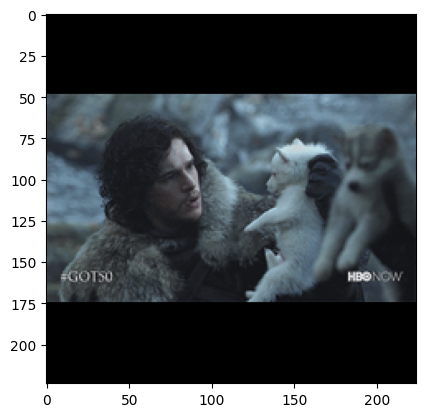

In [2]:
gif_path = f"{config()['data_path']}/{config()['test_gif_name']}"
frames = gif_utils.frames_from_gif(gif_path)
print(frames.shape, frames.dtype)
plt.imshow(frames[9].astype(int))

In [3]:
files = os.listdir(config()["data_path"])
labels = [file.split("_")[0] for file in files]
files_train, files_temp = model_selection.train_test_split(files, test_size=0.4, stratify=labels, random_state=0)
labels_temp = [file.split("_")[0] for file in files_temp]
files_val, files_test = model_selection.train_test_split(files_temp, test_size=0.5, stratify=labels_temp, random_state=0)
pd.Series(labels_temp).value_counts()

5    20
6    20
8    20
1    20
0    20
2    20
9    20
3    20
7    20
4    20
Name: count, dtype: int64

In [4]:
def generator(files):
    for file in files:
        file = str(file, "utf-8")
        frames = gif_utils.frames_from_gif(f"{config()['data_path']}/{file}")
        label = int(file.split("_")[0])
        yield frames, label
output_signature = (
    tf.TensorSpec(shape=(10, 224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)
ds_train = tf.data.Dataset.from_generator(generator, args=[files_train], output_signature=output_signature)
ds_val = tf.data.Dataset.from_generator(generator, args=[files_val], output_signature=output_signature)
ds_test = tf.data.Dataset.from_generator(generator, args=[files_test], output_signature=output_signature)
ds_train = ds_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(2)
ds_val = ds_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(2)
ds_test = ds_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(2)

2023-12-06 19:04:02.749284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 19:04:02.749489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 19:04:02.749545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 19:04:03.576044: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 19:04:03.576136: I external/local_xla/xla/stream_executor

# Model training

In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(0)

net = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# net = tf.keras.applications.EfficientNetB0(include_top=False)
# net = tf.keras.applications.EfficientNetB5(include_top=False)
# net = tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(config()["num_classes"]),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.fit(ds_train,
          epochs=10,
          validation_data=ds_val,
          callbacks=tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"))

model.summary()
model_path = f"{config()['models_path']}/{config()['model_name']}.keras"
model.save(model_path)

In [ ]:
# from official.projects.movinet.modeling import movinet
# from official.projects.movinet.modeling import movinet_model

# model_id = "a0"
# resolution = 224

# tf.keras.backend.clear_session()

# backbone = movinet.Movinet(model_id=model_id)
# backbone.trainable = False

# # Set num_classes=600 to load the pre-trained weights from the original model
# model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
# model.build([None, None, None, None, 3])

# checkpoint_dir = f"movinet_{model_id}_base"
# checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint = tf.train.Checkpoint(model=model)
# status = checkpoint.restore(checkpoint_path)
# status.assert_existing_objects_matched()

In [ ]:
# def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
#   '''Builds a classifier on top of a backbone model.'''
#   model = movinet_model.MovinetClassifier(
#       backbone=backbone,
#       num_classes=num_classes)
#   model.build([batch_size, num_frames, resolution, resolution, 3])

#   return model

In [ ]:
# model = build_classifier(2, 10, resolution, backbone, 10)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"]
# )

# model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=2,
#     validation_freq=1,
#     verbose=1
# )

# Export model

In [ ]:
keras_model_path = f"{config()['models_path']}/{config()['model_name']}.keras"
onnx_model_path = f"{config()['models_path']}/{config()['model_name']}.onnx"
keras_model = keras.models.load_model(keras_model_path)
# model_proto, _ = tf2onnx.convert.from_keras(keras_model, output_path=onnx_model_path)
# output_names = [n.name for n in model_proto.graph.output]

In [ ]:
session = ort.InferenceSession(onnx_model_path)
gif_path = f"{config()['data_path']}/{config()['test_gif_name']}"
input = gif_utils.frames_from_gif(gif_path)
input = np.expand_dims(input, axis=0)
keras_pred = keras_model.predict(input)
onnx_pred = session.run(None, {"time_distributed_input": input})

print("Keras predicted", keras_pred)
print("ONNX predicted:", onnx_pred[0])

# Make sure ONNX and Keras have the same results
np.testing.assert_allclose(keras_pred, onnx_pred[0], rtol=1e-5)

In [5]:
mlflow.set_tracking_uri(config()["mlflow_tracking_uri"])
mlflow.set_experiment(config()["mlflow_experiment_name"])
# with mlflow.start_run():
#     signature = infer_signature(input, np.array(onnx_pred))
#     onnx_model = onnx.load_model(onnx_model_path)
#     mlflow.onnx.log_model(
#         onnx_model,
#         artifact_path="onnx_model",
#         registered_model_name=config()["model_name"],
#         signature=signature
#     )

<Experiment: artifact_location='mlflow-artifacts:/83f5f337909f41988c4dca5b2b12b3d0', creation_time=1701014473840, experiment_id='0', last_update_time=1701097438947, lifecycle_stage='active', name='default', tags={}>

In [15]:
mlflow_client = mlflow.MlflowClient()
models = mlflow_client.search_model_versions()
# models = mlflow_client.search_registered_models()
for x in models:
    pprint(dict(x), indent=4)

{   'aliases': [],
    'creation_timestamp': 1701855047721,
    'current_stage': 'None',
    'description': '',
    'last_updated_timestamp': 1701859058908,
    'name': 'baseline',
    'run_id': '2bd605a2a0f94a44b0e3bc22737e77fb',
    'run_link': '',
    'source': 'runs:/2bd605a2a0f94a44b0e3bc22737e77fb/onnx_model',
    'status': 'READY',
    'status_message': '',
    'tags': {},
    'user_id': '',
    'version': '2'}
{   'aliases': [],
    'creation_timestamp': 1701097875853,
    'current_stage': 'None',
    'description': '',
    'last_updated_timestamp': 1701097875853,
    'name': 'baseline',
    'run_id': '7a45d101dde04f59b34cadc0effdbd64',
    'run_link': '',
    'source': 'mlflow-artifacts:/83f5f337909f41988c4dca5b2b12b3d0/7a45d101dde04f59b34cadc0effdbd64/artifacts/onnx_model',
    'status': 'READY',
    'status_message': '',
    'tags': {},
    'user_id': '',
    'version': '1'}


In [7]:
mlflow_client.set_registered_model_alias(config()["model_name"], "champion", "1")
mlflow_client.set_registered_model_alias(config()["model_name"], "challenger", "2")

In [13]:
mlflow_client.delete_registered_model_alias(config()["model_name"], "challenger")

In [10]:
champion_model = mlflow_client.get_model_version_by_alias('baseline', 'champion')

In [ ]:
model_name = 'baseline'
alias = 'champion'
model = mlflow.onnx.load_model(f'models:/{model_name}@{alias}')
onnx.save_model(model, f'../layers/models/{model_name}_{alias}.onnx')

# Error analysis

In [ ]:
def get_actual_predicted_labels(dataset): 
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [ ]:
labels = range(config()["num_classes"])
actual, predicted = get_actual_predicted_labels(ds_test)
plot_confusion_matrix(actual, predicted, labels)

In [ ]:
gif_path = f"{config()['data_path']}/{config()['test_gif_name']}"
sample = gif_utils.frames_from_gif(gif_path)
sample = np.expand_dims(sample, axis=0)
print(gif_path)
with tf.device("/CPU:0"):
    prediction = model.predict(sample)
    print(prediction)
    print(tf.argmax(prediction[0]).numpy())
plt.imshow(sample[0][0].astype("int"))